In [17]:
import geopandas as gpd # for geospatial data handling
import pandas as pd
import osmnx as ox # for handling data from OpenStreetMap (osm) with the help of networkX (nx)
import contextily as cx # for plotting
import matplotlib.pyplot as plt # for plotting
from pyproj import CRS # for more advanced CRS modifications and transformations
from shapely.geometry import Polygon
import numpy as np
import pandana 
import os

In [18]:
#amenities_with_neighborhood.to_file("amenities_with_neighborhood.geojson", driver='GeoJSON')
amenities_with_neighborhood = gpd.read_file('/Users/caro/Desktop/SPRING24/GDS/PROJECT/GDS_project/dataframes/amenities_with_neighborhood.geojson')

In [19]:
neighbourhoods = list(amenities_with_neighborhood['Arrondissement'].unique())[:-1]
neighbourhoods = [neighborhood + ', Montreal, Canada' for neighborhood in neighbourhoods]

In [ ]:
place = 'Montreal, Canada'
type_of_transportation = 'walk'
tags = {'amenity': ['restaurant', 'cafe']}

walk_time = 15  # max walking horizon in minutes
walk_speed = 5  # km per hour
walk_time_sec = walk_time * 60 # We need the time in seconds to match how travel time is calculated in OSMnx

In [20]:
amenities = ox.features_from_place(place, tags=tags)
amenities = amenities.to_crs('EPSG:25832')
# Some amenities might be polygons, but we need them as points, so let's extract the centroids from the amenities' geometries
centroids = amenities.centroid

In [26]:
# RUN ONLY ONCE TO SAVE THE GRAPHS - ALREADY DONE

graphs = {}

# specify parameters for the analysis
walk_time = 15  # max walking horizon in minutes
walk_speed = 5  # km per hour
walk_time_sec = walk_time * 60 # We need the time in seconds to match how travel time is calculated in OSMnx

# Loop through the neighborhoods
for neighborhood in neighbourhoods:
    # Create a graph for the current neighborhood
    G_walk_neighborhood = ox.graph_from_place(neighborhood, network_type=type_of_transportation) # type of transportation is set here

    for u, v, data in G_walk_neighborhood.edges(data=True):
        data['speed_kph'] = walk_speed
    G_walk_neighborhood = ox.add_edge_travel_times(G_walk_neighborhood) # this computes the travel time in seconds based on the 'speed_kph' column

    ox.save_graphml(G_walk_neighborhood, f"/Users/caro/Desktop/SPRING24/GDS/PROJECT/GDS_PROJECT/graphs/G_walk_{neighborhood}.graphml") # save graph per neighbourhood   
    # Store the graph in the dictionary using the neighborhood name as the key
    graphs[neighborhood] = G_walk_neighborhood

KeyboardInterrupt: 

In [59]:
graphs = {}
graphs_dir = '/Users/caro/Desktop/SPRING24/GDS/PROJECT/GDS_project/graphs'

for file_name in os.listdir(graphs_dir):
    if file_name.endswith(".graphml"):
        neighborhood = file_name.replace("G_walk_", "").replace(".graphml", "")
        file_path = os.path.join(graphs_dir, file_name)
        G_walk_neighborhood = ox.load_graphml(file_path)

        graphs[neighborhood] = G_walk_neighborhood


In [66]:
import pandana
pandanas = {}
# Build Pandana network for each neighborhood
for neighborhood, graph in graphs.items():
    graph_projected = ox.project_graph(graph, to_crs='EPSG:25832')
    nodes = ox.graph_to_gdfs(graph_projected, edges=False)[['x', 'y']]
    edges = ox.graph_to_gdfs(graph_projected, nodes=False).reset_index()[['u', 'v', 'travel_time']]

    pandana_network = pandana.Network(node_x=nodes['x'],
                            node_y=nodes['y'], 
                            edge_from=edges['u'],
                            edge_to=edges['v'],
                            edge_weights=edges[['travel_time']])
    
    pandanas[neighborhood] = pandana_network

Generating contraction hierarchies with 4 threads.
Setting CH node vector of size 9639
Setting CH edge vector of size 30838
Range graph removed 31100 edges of 61676
. 10% . 20% . 30% . 40% . 50% . 60% . 70% . 80% . 90% . 100%
Generating contraction hierarchies with 4 threads.
Setting CH node vector of size 14281
Setting CH edge vector of size 46136
Range graph removed 46506 edges of 92272
. 10% . 20% . 30% . 40% . 50% . 60% . 70% . 80% . 90% . 100%
Generating contraction hierarchies with 4 threads.
Setting CH node vector of size 14970
Setting CH edge vector of size 48624
Range graph removed 48876 edges of 97248
. 10% . 20% . 30% . 40% . 50% . 60% . 70% . 80% . 90% . 100%
Generating contraction hierarchies with 4 threads.
Setting CH node vector of size 2588
Setting CH edge vector of size 8290
Range graph removed 8386 edges of 16580
. 10% . 20% . 30% . 40% . 50% . 60% . 70% . 80% . 90% . 100%
Generating contraction hierarchies with 4 threads.
Setting CH node vector of size 9720
Setting C

In [67]:
walking_distances = {}  # Dictionary to store walking distances

for neighborhood, pandana in pandanas.items():
    pandana.set_pois(category='restaurant', # amenity set here
                     maxdist=walk_time_sec,
                     maxitems=3,
                     x_col=centroids.x, 
                     y_col=centroids.y)
    
    distances = pandana.nearest_pois(distance=walk_time_sec,
                                      category='restaurant', # amenity set here
                                      num_pois=3)
    
    distances['travel_time'] = distances[1] / 60
    walking_distances[neighborhood] = distances

In [68]:
G_walk_anjou = graphs['Le Sud-Ouest, Montreal, Canada'] # access one graph
pandana_anjou = pandanas['Le Sud-Ouest, Montreal, Canada'] # access one pandana network
distances_anjou = walking_distances['Le Sud-Ouest, Montreal, Canada']

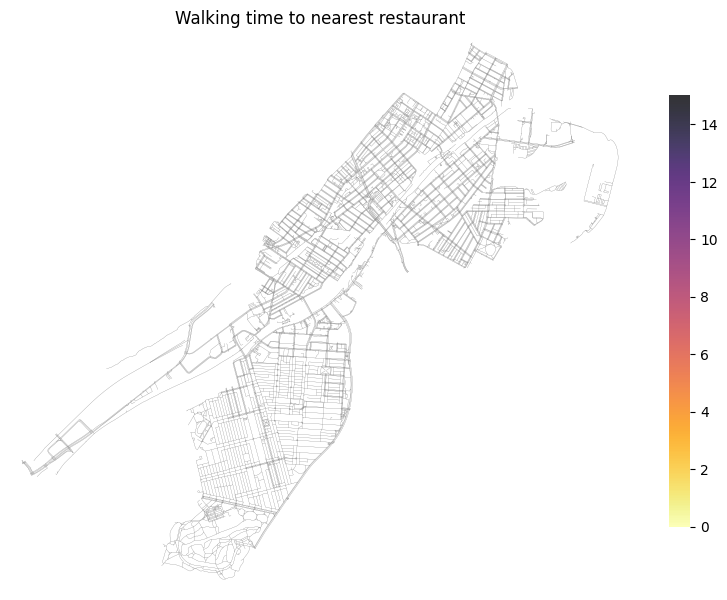

In [69]:
fig, ax = plt.subplots(figsize=(10, 8))

# Plot distance to nearest amenity from each node
ox.plot_graph(G_walk_anjou, ax=ax, node_size=0, edge_linewidth=0.1,
                        edge_color='gray', show=False, close=False)

nodes_anjou = pandana_anjou.nodes_df[['x', 'y']]

sc = ax.scatter(x=nodes_anjou['x'],
                y=nodes_anjou['y'], 
                c=distances_anjou['travel_time'], # column to plot (distance to nearest store)
                s=1, # size
                cmap='inferno_r',
                edgecolors='none',
                alpha=0.8)

ax.set_title('Walking time to nearest restaurant')
plt.colorbar(sc, shrink=0.7).outline.set_edgecolor('none')

In [54]:
nodes_anjou

,x,y
osmid,,
224886238,-4.955472e+06,9.196841e+06
596644170,-4.955159e+06,9.196618e+06
4502353385,-4.955782e+06,9.197060e+06
224911443,-4.956666e+06,9.197691e+06
8875463868,-4.956651e+06,9.197680e+06
...,...,...
11662037419,-4.959223e+06,9.193082e+06
11662037462,-4.959074e+06,9.193028e+06
11662037420,-4.959213e+06,9.193122e+06


In [28]:
nodes_anjou['y']

osmid
224886238      9.196841e+06
596644170      9.196618e+06
4502353385     9.197060e+06
224911443      9.197691e+06
8875463868     9.197680e+06
                   ...     
11662037419    9.193082e+06
11662037462    9.193028e+06
11662037420    9.193122e+06
11662037457    9.193039e+06
11662037426    9.193093e+06
Name: y, Length: 3200, dtype: float64

In [50]:
distances_anjou

,1,2,3,travel_time
osmid,,,,
224886238,348.299988,751.000000,900.000000,5.805000
596644170,547.799988,900.000000,900.000000,9.130000
4502353385,151.600006,554.299988,900.000000,2.526667
224911443,9.500000,412.200012,429.399994,0.158333
8875463868,0.000000,402.700012,438.899994,0.000000
...,...,...,...,...
11662037419,223.699997,223.699997,223.699997,3.728333
11662037462,306.000000,306.000000,306.000000,5.100000
11662037420,244.399994,244.399994,244.399994,4.073333


In [53]:
nodes_anjou

,x,y
osmid,,
224886238,-4.955472e+06,9.196841e+06
596644170,-4.955159e+06,9.196618e+06
4502353385,-4.955782e+06,9.197060e+06
224911443,-4.956666e+06,9.197691e+06
8875463868,-4.956651e+06,9.197680e+06
...,...,...
11662037419,-4.959223e+06,9.193082e+06
11662037462,-4.959074e+06,9.193028e+06
11662037420,-4.959213e+06,9.193122e+06
